# Complex Network Analysis

Complex Network Analysis (CNA) di [LastFM Asia Social Network](https://snap.stanford.edu/data/lastfm_asia.zip).

_Ho dovuto scegliere_ questo dataset per ragioni computazionali. Infatti, `nx.draw` usa l'algoritmo `nx.spring_layout` per posizionare i nodi. 
Ovviamente all'aumentare del numero di nodi aumenta anche il tempo richiesto per completare questo task. [Questo](https://github.com/networkx/networkx/blob/e9626085d089cf107d5717288d0c5e61b86ba22e/networkx/drawing/layout.py#L459-L493) perché l'algoritmo inizialmente riempe un NumPy array chiamato `pos` con valori casuali generati da `seed.rand`, e poi li aggiorna per $50$ `iterations` (il default).

## Import packages

In [1]:
import zipfile
from collections import Counter
from io import BytesIO as StringIO

import matplotlib.pyplot as plt
from random import randint
import networkx as nx
import numpy as np

### Setup plotting

In [2]:
%matplotlib inline

## Caricamento del dataset

Tratto da [Sampson](https://github.com/networkx/networkx/blob/f957028/examples/drawing/plot_sampson.py)

In [3]:
with zipfile.ZipFile("data/lastfm_asia.zip") as zf:
    dataset = StringIO(zf.read("lasftm_asia/lastfm_asia_edges.csv"))

next(dataset, '')  # skip header line

b'node_1,node_2\n'

Creiamo la rete dal dataset appena letto

In [4]:
G: nx.Graph = nx.read_edgelist(dataset, delimiter=',', nodetype=int, encoding="utf-8", create_using=nx.Graph())

Calcoliamo la posizione dei nodi per i futuri plotting. Useremo l'algoritmo di default.

In [5]:
pos: dict = nx.spring_layout(G, weight=None)

Determiniamo la degree sequence

In [6]:
degree_sequence = [d for _, d in G.degree()]

## Topologia della rete

Numero totale di nodi:

In [7]:
V = G.number_of_nodes()
V

7624

Numero totale di archi:

In [8]:
E = G.number_of_edges()
E

27806

In [9]:
density = nx.density(G)
density

0.0009568849118596328

La rete è sparsa.

Grado medio della rete:

In [10]:
avg_degree = np.mean(degree_sequence)
avg_degree

7.2943336831059815

Dizionario contenete i cammini minimi tra tutte le coppie:

In [11]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

La funzione `nx.all_pairs_shortest_path_length` richiede parecchio tempo per essere computata, quindi è opportuno salvarsi l'output e riutilizzarlo più avanti.

In [12]:
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

15

Non ho usato `nx.diameter` perché quest'ultimo ricalcolerebbe i cammini minimi tra tutte le coppie, ma io ce li ho già.

## Modelli per confronto

Genero una rete di Erdős–Rényi con $V$ nodi e $p = $`density`. Inoltre per un miglior confronto si ricerca una rete connessa. Quindi si è impostato il `seed` a $1347$.

In [13]:
Gr: nx.Graph = nx.fast_gnp_random_graph(V, density, seed=1347)
shortest_path_lengths_r = dict(nx.all_pairs_shortest_path_length(Gr))
diameter_r = max(nx.eccentricity(Gr, sp=shortest_path_lengths_r).values())

## Clustering Effects

In [14]:
nx.average_clustering(G)

0.2194184243270858

In [15]:
triangles_per_node = list(nx.triangles(G).values())
sum(triangles_per_node) / 3 # I don't want to count a triangle three times

40433.0

## Hub

Parametro $\kappa$ di eterogeneità della distribuzione di grado

In [16]:
second_raw_moment = np.mean([pow(k, 2) for k in degree_sequence])
kappa = second_raw_moment / pow(avg_degree, 2)
kappa

3.4851801801477875

`kappa` $\gg 1$ perciò ho eterogeneità di grado. Mi aspetto di avere un'ampia distribuzione di grado.

Individuiamo l'ampiezza di tale distribuzione.

In [17]:
highest_degree_node = max(G.nodes, key=G.degree)
lowest_degree_node = min(G.nodes, key=G.degree)

highest_degree = G.degree(highest_degree_node)
lowest_degree = G.degree(lowest_degree_node)

lowest_degree, highest_degree

(1, 216)

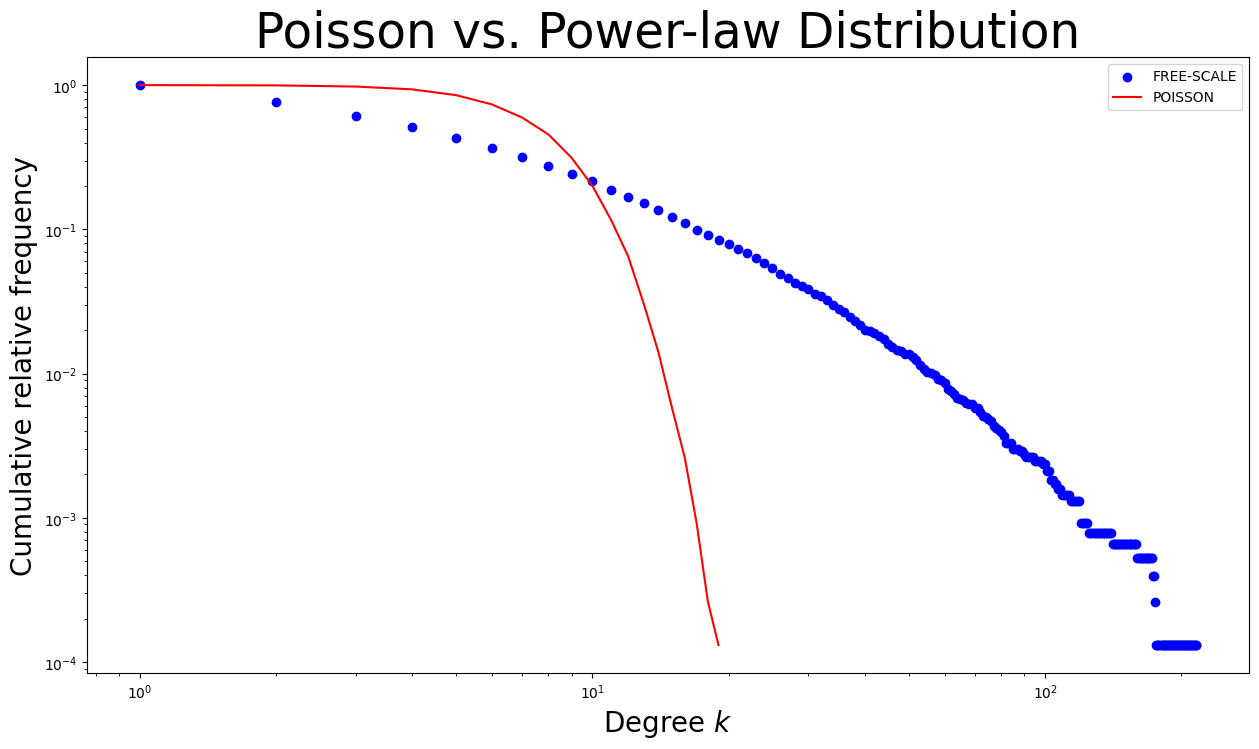

In [18]:
plt.figure(figsize=(15, 8))
ax = plt.gca()

# degree distribution for free-scale network
degree_counts = Counter(degree_sequence)
plot_x = list(range(lowest_degree, highest_degree + 1))
f_v = [degree_counts.get(x, 0) for x in plot_x]
plot_y = [sum(f_v[x - 1:]) / degree_counts.total() for x in plot_x]
ax.scatter(plot_x, plot_y, c='b', label='FREE-SCALE')

# degree distribution for real network based on my dataset
degree_counts_r = Counter([d for _, d in Gr.degree()])
plot_x = list(range(Gr.degree(min(Gr.nodes, key=Gr.degree)), Gr.degree(max(Gr.nodes, key=Gr.degree)) + 1))
f_v = [degree_counts_r.get(x, 0) for x in plot_x]
plot_y = [sum(f_v[x - 1:]) / degree_counts_r.total() for x in plot_x]
ax.plot(plot_x, plot_y, c='r', label='POISSON')

ax.set_title("Poisson vs. Power-law Distribution", fontdict={"size": 35}, loc="center")
plt.xlabel('Degree ' + r'$k$', fontdict={"size": 20})
plt.ylabel('Cumulative relative frequency', fontdict={"size": 20})
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend(loc='upper right')
plt.show()

Consideriamo che lo scatter è stato tracciato sulla base delle [_frequenze relative_](https://barabasi.com/f/623.pdf#page=46) e _non_ sulla base delle probabilità. A ogni modo si riconosce l'andamento heavy-tail. Questo rafforza ulteriormente la convinzione dell'esistenza di hub. Possiamo affermare che la rete è scale-free.
 Inoltre la distribuzione presenta [_low-degree saturation_ e _high-degree cutoff_](https://barabasi.com/f/623.pdf#page=47). Il primo fenomeno si registra in alto a sinistra. Mentre il secondo è dovuto principalmente ha incompletezza di dati: uso di frequenze piuttosto che di probabilità. Più nello specifico la rete presenta hub, ma oltre alla presenza di un _solo_ nodo con $216$ vicini, non troviamo molti altri nodi con $k<216$ vicini. Come si può vedere dal codice di esempio qui sotto.

In [19]:
for k in range(highest_degree, highest_degree - 5, -1):
    print(f"#nodes with {k} neighbors:", degree_counts.get(k, 0))

#nodes with 216 neighbors: 1
#nodes with 215 neighbors: 0
#nodes with 214 neighbors: 0
#nodes with 213 neighbors: 0
#nodes with 212 neighbors: 0


Per tanto la distribuzione di grado non segue _esattamente_ una power law ( $p_k\sim k^{-\gamma}$ ), di cui non è stato [stimato il degree exponent](https://barabasi.com/f/623.pdf#page=48) $\gamma$.
Mentre la curva rossa evidenzia la distribuzione di Poisson della rete random costruita sulla topologia di quella del dataset, come si evince vi è un numero maggiore di nodi con basso grado, ma pochi hanno alto grado: perché questo non è possibile in tale modello.

Infine plottiamo la rete mettendo in evidenza i nodi in base al loro grado.

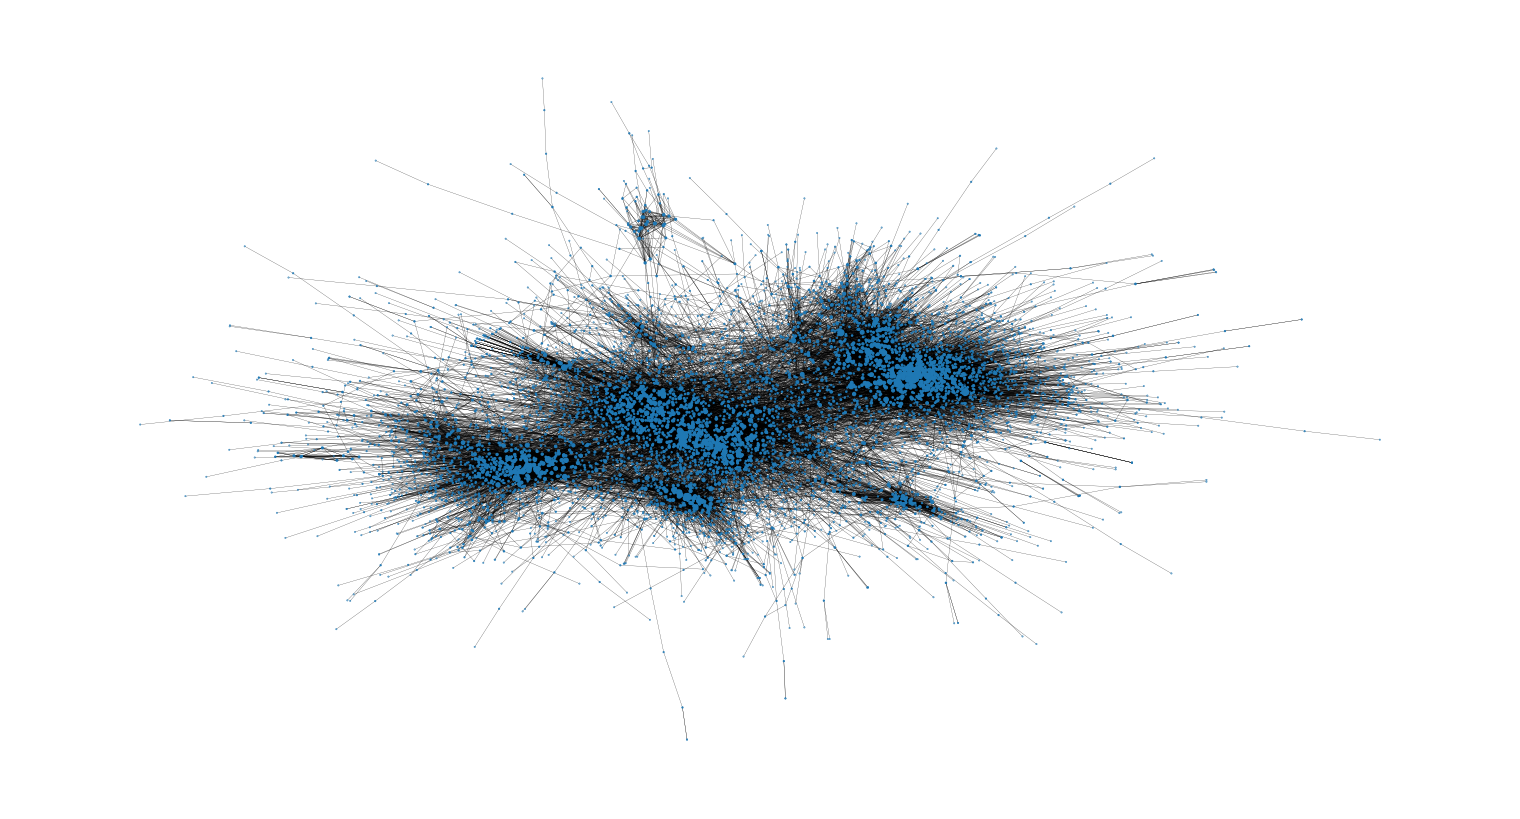

In [20]:
node_size = [v * 1000 for v in
             nx.centrality.degree_centrality(G).values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw(G, pos=pos, node_size=node_size, width=.15)

## Assortativity

Chiediamoci se vi è o meno omofilia di grado.

In [21]:
nx.degree_pearson_correlation_coefficient(G)

0.017073172560631802

`nx.degree_pearson_correlation_coefficient`, come è intuibile, si comporta come il coefficiente di correlazione di Pearson. Quindi il valore appena ottenuto ci suggerisce una rete neutrale. Questo significa che gli hub _non sono prevalentemente_ collegati con nodi con basso grado e viceversa. O per meglio dire i nodi (con alto/basso grado) sono collegati tra loro in maniera casuale. Questo non significa che una rete neutrale è una random network, come ho avuto modo di mostrare.

## Small-world

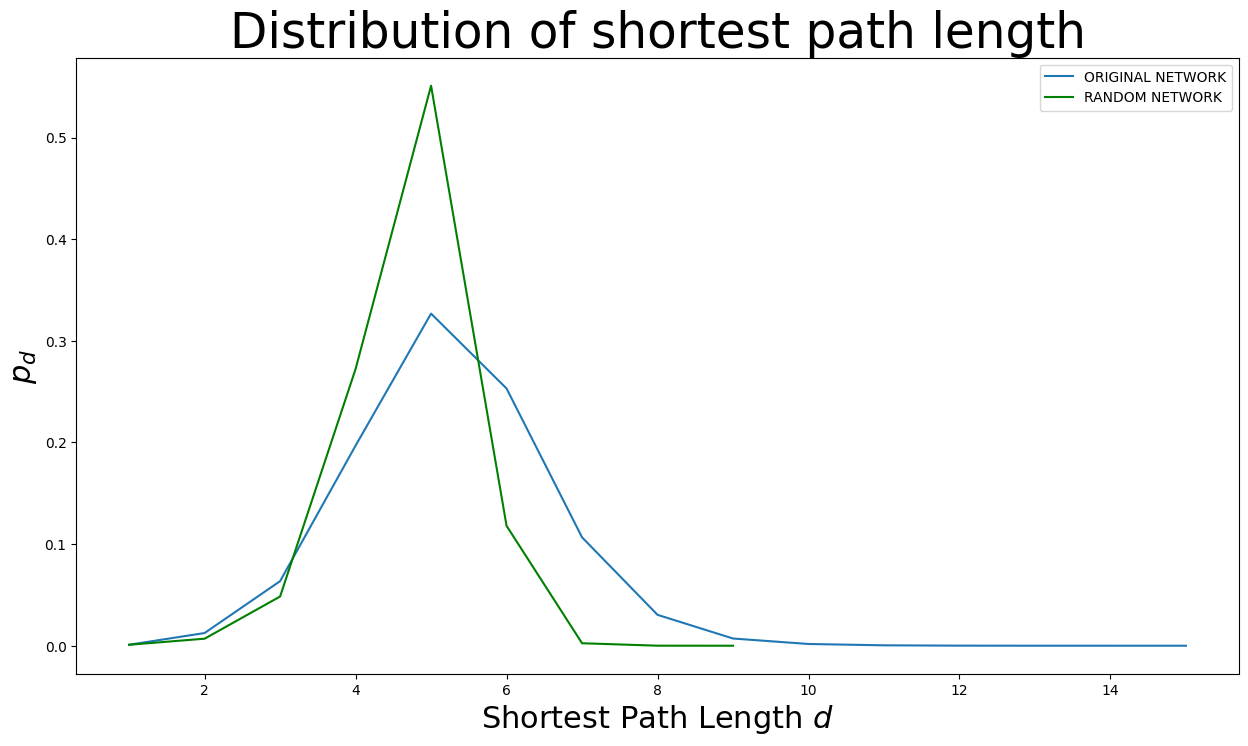

In [22]:
fig, ax = plt.subplots(figsize=(15,8))

path_lengths = np.zeros(diameter + 1, dtype=int)
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts
relative_freq = path_lengths[1:] / path_lengths[1:].sum()
ax.plot(np.arange(1, diameter + 1), relative_freq, label='ORIGINAL NETWORK')

path_lengths = np.zeros(diameter_r + 1, dtype=int)
for pls in shortest_path_lengths_r.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts
relative_freq = path_lengths[1:] / path_lengths[1:].sum()
ax.plot(np.arange(1, diameter_r + 1), relative_freq, color='green', label='RANDOM NETWORK')

ax.set_title("Distribution of shortest path length", fontdict={"size": 35}, loc="center")
ax.set_xlabel("Shortest Path Length " + r'$d$', fontdict={"size": 22})
ax.set_ylabel(r'$p_{d}$', fontdict={"size": 22})
plt.legend(loc='upper right')

plt.show()

Sicuramente la rete gode della proprietà di small-world, come mi aspettavo vista la presenza di hub. A ogni modo è difficile dire se gode della proprietà dell'ultra small-world: infatti la rete non mostra un netto staccamento rispetto alla corrispondente rete casuale, che ovviamente ha $\langle d \rangle \approx \log_{k}V$. Maggiori informazioni possono essere ottenute effettuando la stessa analisi su un'evoluzione di questa rete che comprenda un [maggior numero di nodi](https://barabasi.com/f/623.pdf#page=22).

## Network Community

Confronto i vari algoritmi visti a lezione e plotto quello con modularity maggiore. Si noti che il dataset scelto non dispone di una ground-truth per stabilire quale sia il partizionamento più appropriato. Per tanto non ne esiste uno migliore di un altro, visto che tutti presentano una `modularity` $>0.5$.

In [23]:
label_propagation = nx.community.label_propagation_communities(G)
print("# communities:", len(label_propagation))
print("modularity:", nx.community.modularity(G, label_propagation, weight=None))

# communities: 650
modularity: 0.7522556757225006


L'algoritmo più appropriato visto a lezione è `nx.community.naive_greedy_modularity_communities`. Tuttavia questo ha complessità $O( |V|^{4} )$, che è proibitiva per la mia rete. Ripiegherò su un'ottimizzazione.

In [24]:
newman_greedy = nx.community.greedy_modularity_communities(G)
print("# communities:", len(newman_greedy))
print("modularity:", nx.community.modularity(G, newman_greedy, weight=None))

# communities: 43
modularity: 0.7959763704358901


La funzione `nx.community.louvain_communities` restituisce il partizionamento con modularity maggiore. Infatti, come per il Girvan-Newman, anche questo approccio costruisce un dendogramma. Qualora si volesse esplorarlo basta usare `nx.community.louvain_partitions`, che "ritorna" un generatore, in maniera tale che l'operazione non sia bloccante.
Inoltre il numero di componenti trovate è lo stesso di Gephi.

In [25]:
louvain = nx.community.louvain_communities(G, weight=None)
print("# communities:", len(louvain))
print("modularity:", nx.community.modularity(G, louvain, weight=None))

# communities: 30
modularity: 0.8146973857758388


Si è omesso `nx.community.girvan_newman` per una questione computazionale. Infatti l'algoritmo, come `nx.community.louvain_partitions`, fornisce un generatore. Quindi per scoprire a quale livello del dendogramma massimizziamo la modularity è necessario prima costruirlo _tutto_. Questo comporta che a ogni rimozione o successiva invocazione della funzione `_without_most_central_edges` è necessario valutare nuovamente la `nx.edge_betweenness_centrality`, che computazionalmente gravosa, almeno su una rete con $|E| = 27806$.

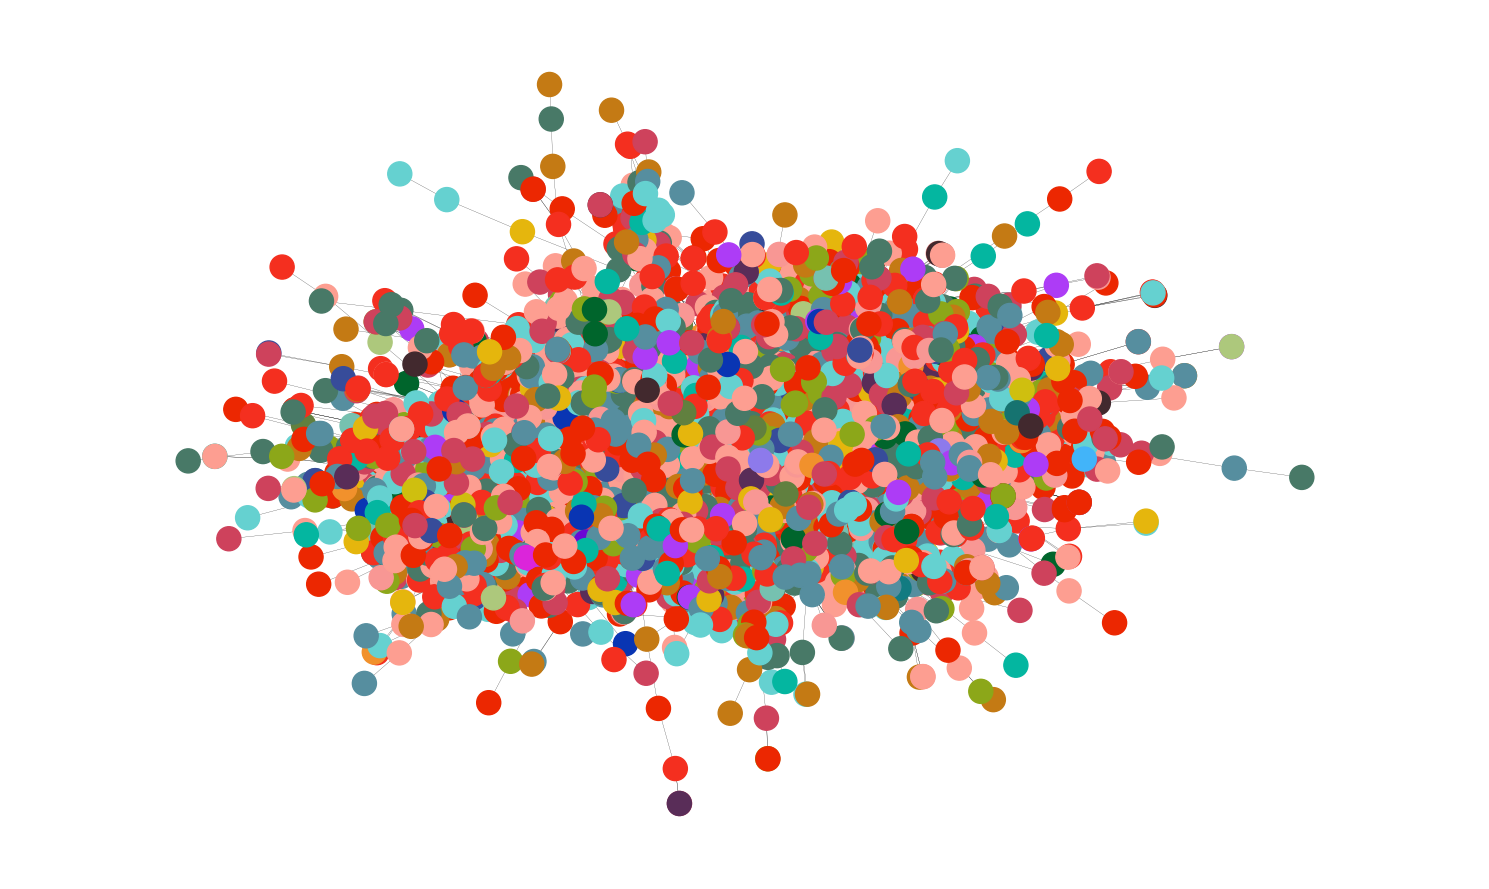

In [26]:
colors = [""] * V
for com in louvain:
    color = "#%06X" % randint(0, 0xFFFFFF)
    for node in list(com):
        colors[node] = color

fig, ax = plt.subplots(figsize=(15, 9))
nx.draw(G, pos=pos, width=.15, node_color=colors)

ax.margins(.1, .05)
fig.tight_layout()
plt.axis("off")
plt.show()